In [289]:
# imports
import numpy as np
import scipy as scp
from scipy.sparse import coo_matrix
import scipy.sparse.linalg as linalg
import scipy.io
from scipy.ndimage.filters import gaussian_filter as gauss
import matplotlib.pylab as plt
import matplotlib as mpl

## 1 Bias and variance of ridge regression

## 2 Denoising of a CT image

In [209]:
# modified X generating function

def construct_X(M, alphas, Np = None, tau = 0, s0 = None, a0 = None, b0 = None):
    # convert to radians
    alphas = np.array(alphas)*np.pi*180**-1
    
    # number of pixels sensor
    if Np == None:
        Np = np.round(2**0.5*M)
        if Np%2 != 0:
            Np = Np+1

    if s0 == None:
        s0 = (Np-1)/2
        
    if a0 == None:
        a0 = -0.5*M
        
    if b0 == None:
        b0 = -0.5*M
      
    # number of orientations
    No = len(alphas)
    
    # center coordinates of pixel
    Jba = np.mgrid[:M,:M]
    C = np.array([Jba[1].ravel()+a0,Jba[0].ravel()+b0])
    
    # unit vector of orientation
    n = np.array([np.sin(alphas),np.cos(alphas)])
    
    # projection
    p = np.matmul(n.T,C) + s0
    
    # only use p when on the detector
    cond = np.array([np.logical_and(p>0,p<Np),np.logical_and(p>-1,p<Np-1)]).ravel()
    
    # indices
    Npio = Np*np.mgrid[:M**2,:No][1].T
    i_indices = np.array([p.astype(int)+Npio,np.round(p+0.5).astype(int)+Npio]).ravel() *cond
    #j_indices = np.array([np.arange(M**2) for i in range(2*No)]).ravel()*cond
    j_indices = np.array([Jba[1]+M*Jba[0]]*2*No).ravel()*cond
        
    # compute weights
    w1 = np.abs(p-p.astype(int))
    w2 = 1 - w1
    weights = np.array([w2,w1]).ravel()*cond

    shapeX = [int(Np*No), int(M**2)]

    # ridge regression
    if tau != 0:
        D = M**2
        shapeX = [int(Np*No)+D, int(M**2)]
        rr_indices = [int(Np*No)+np.arange(D), np.arange(D)]
        Tau = np.array([tau**0.5 for i in range(D)])
        
        # append to existing arrays
        weights = np.concatenate([weights,Tau])
        i_indices = np.concatenate([i_indices,rr_indices[0]])
        j_indices = np.concatenate([j_indices,rr_indices[1]])
        
        
    # generate X matrix
    X = coo_matrix((weights, (i_indices, j_indices)), shape=(shapeX[0],shapeX[1]), dtype = np.float32)
    
    return X

(-0.5, 99.5, 144.5, -0.5)

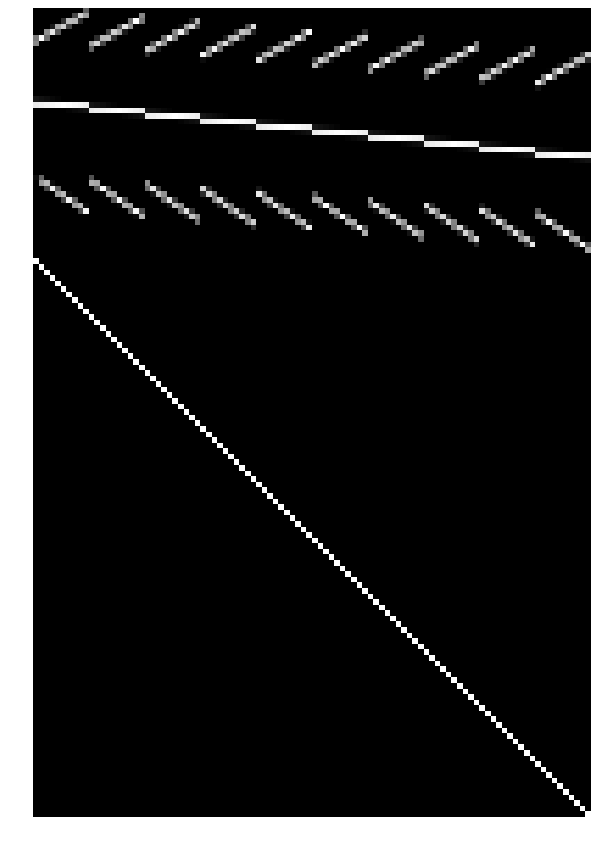

In [210]:
# test matrix generation
X = construct_X(10,np.array([-33,1,42,]),15,1).toarray()

plt.figure(figsize=[10,15])
plt.imshow(X,cmap='gray')
plt.axis('off')

In [ ]:
# image reconstruction

# read in data
alphas_195 = scp.load('hs_tomography/alphas_195.npy')
alphas_77 = scp.load('hs_tomography/alphas_77.npy')

y_195 = scp.load('hs_tomography/y_195.npy')
y_77 = scp.load('hs_tomography/y_77.npy')
X_77_sol = scp.load('hs_tomography/X_77.npy')[()]

In [262]:
# pick specified number of angles
n_projections = 64
Np = 275
index = [int(np.ceil(len(alphas_195) * p/n_projections)) for p in range(n_projections)]
alphas_sub = alphas_195[index]

# collect corresponding measurements from y
y_sub = []
for i in index:
    y_sub.extend(y_195[i*Np : (i+1)*Np])

In [269]:
# compute augmented matrix
Tau = [0,1e1,1e2,1e3,1e4,1e5,1e6]

X_aug = [construct_X(195,alphas_sub+90,275,t,137,-97,-97) for t in Tau]
y_aug = np.concatenate([y_sub,np.zeros(195**2)])

In [270]:
# small matrix
fitres = [linalg.lsqr(A=X_aug[0],b=y_sub,atol=1e-5,btol=1e-5)] + [linalg.lsqr(A=x,b=y_aug,atol=1e-5,btol=1e-5) for x in X_aug[1:]]
b = [f[0] for f in fitres]

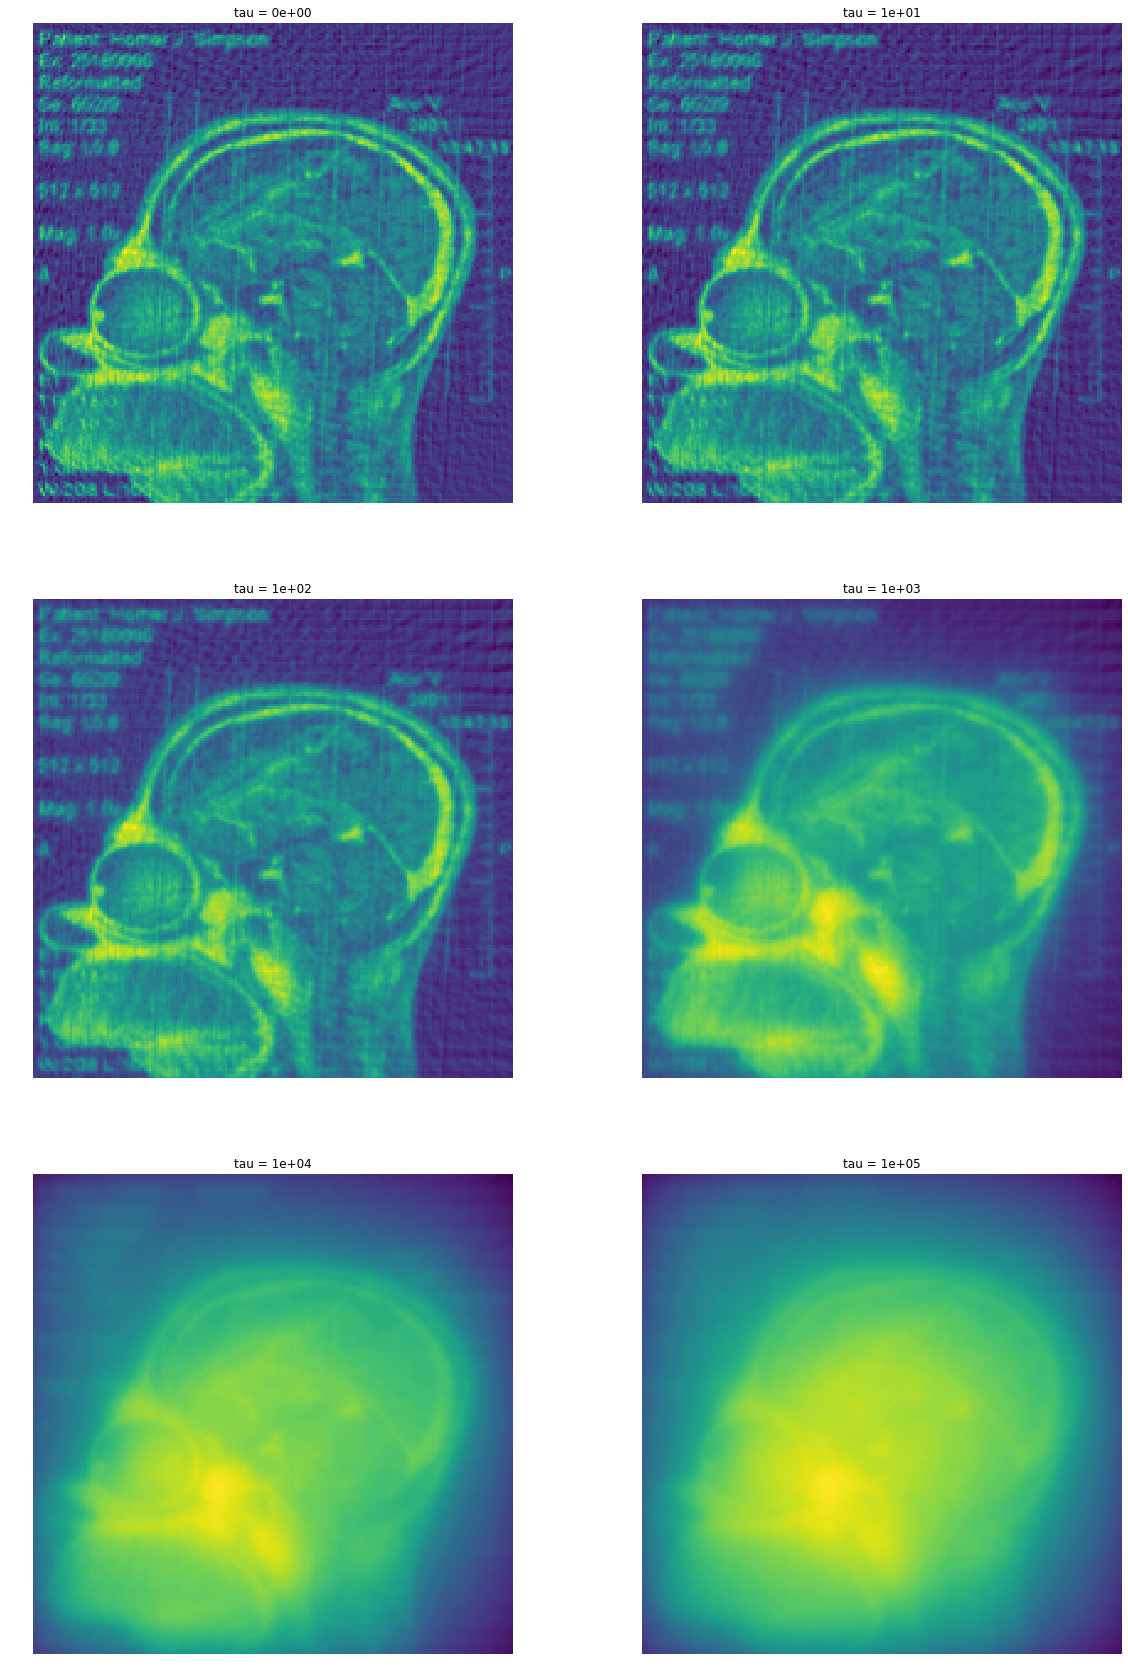

In [271]:
plt.figure(figsize=[20,30])
gs = mpl.gridspec.GridSpec(3, 2)

for i in range(6):
    plt.subplot(gs[i])
    plt.title('tau = %0.0e' %(Tau[i]))
    plt.imshow(b[i].reshape([195,195]))
    plt.axis('off')

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


Text(0, 0.5, 'std image')

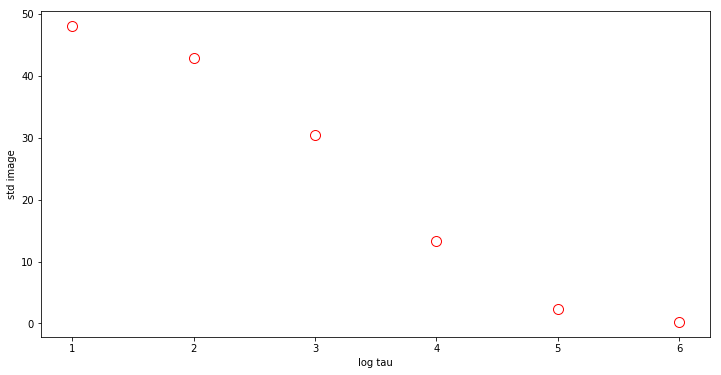

In [287]:
plt.figure(figsize=[12,6])
plt.scatter(np.log10(Tau),np.std(b,axis=1),s=100,facecolor='w',edgecolor='r')
plt.xlabel('log tau')
plt.ylabel('std image')

The standard deviation of pixels shrinks significantly for larger tau, which indicates the reduction of noise. A good trade off between sharpness and noise can be reached for tau inbetween 100 to 1000.

In [296]:
# gaussian filter
sigma = [1,2,3,5,7]
b_gauss = [b[0].reshape([195,195])] + [gauss(b[0].reshape([195,195]),s) for s in sigma]

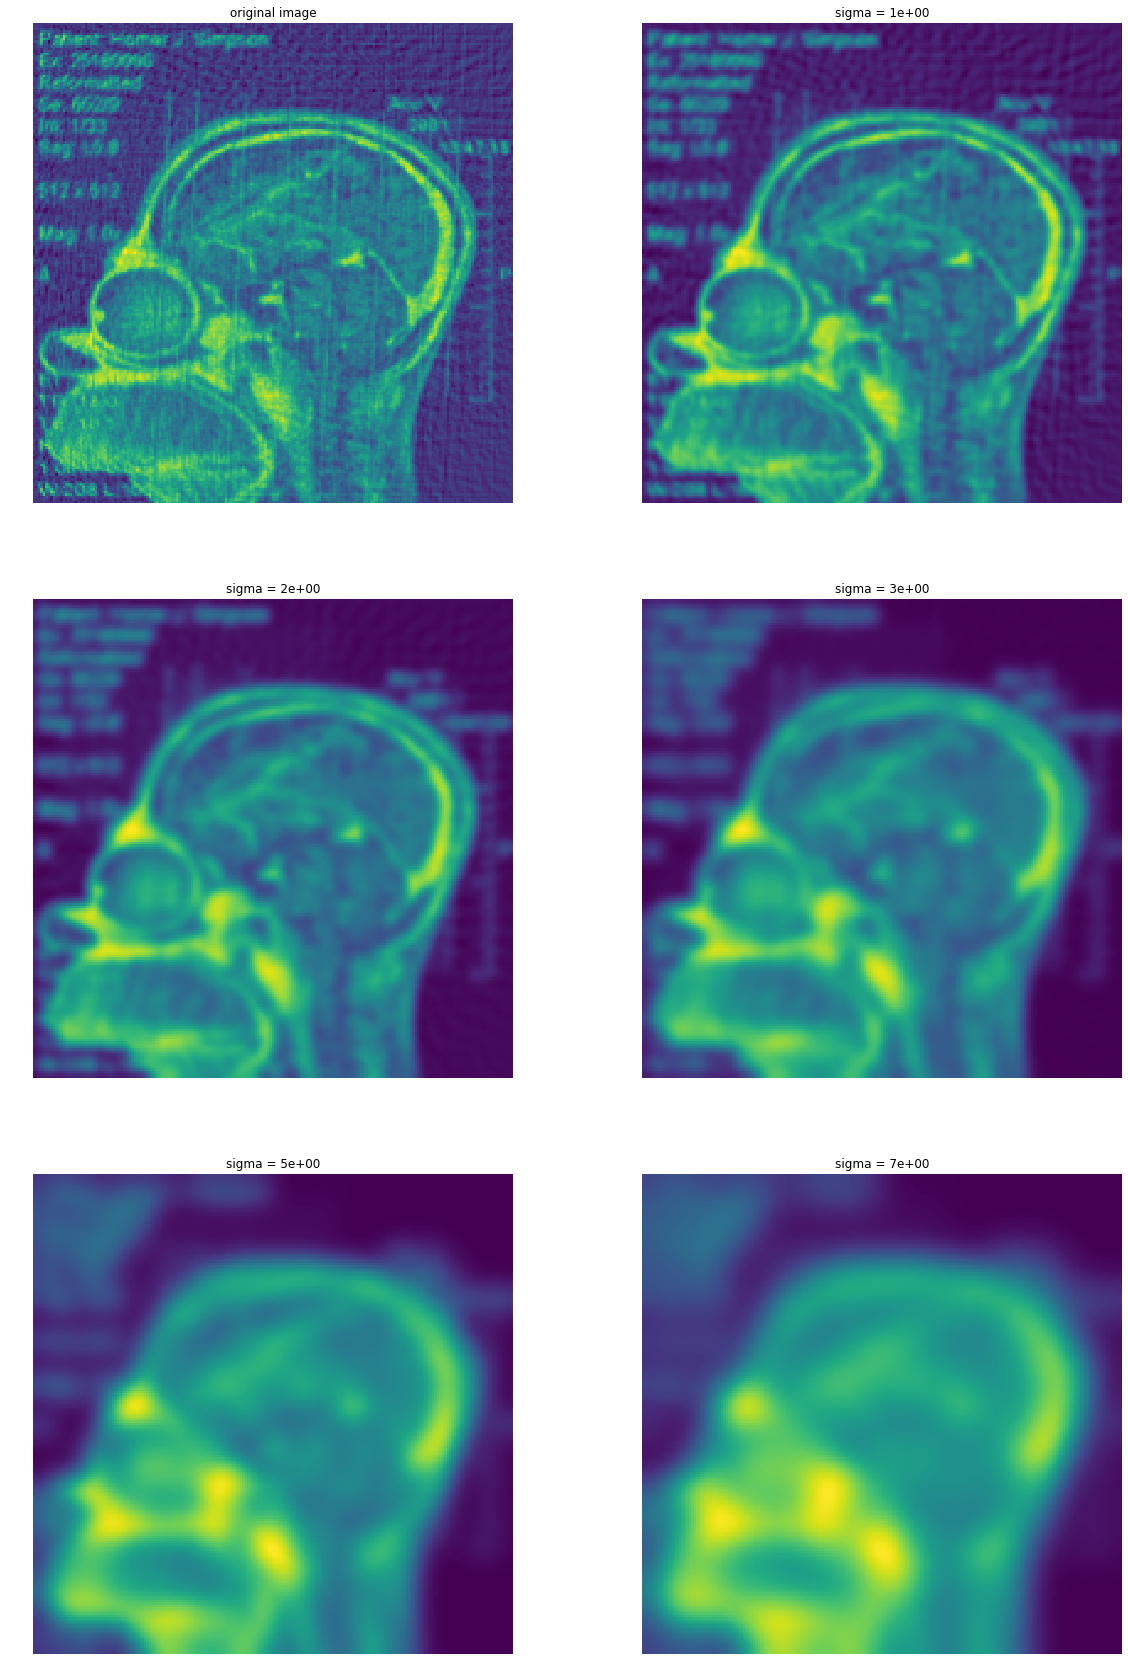

In [298]:
plt.figure(figsize=[20,30])
gs = mpl.gridspec.GridSpec(3, 2)

for i in range(6):
    plt.subplot(gs[i])
    if i == 0:
        plt.title('original image')
    else:
        plt.title('sigma = %0.0e' %(sigma[i-1]))
    plt.imshow(b_gauss[i])
    plt.axis('off')

Text(0, 0.5, 'std image')

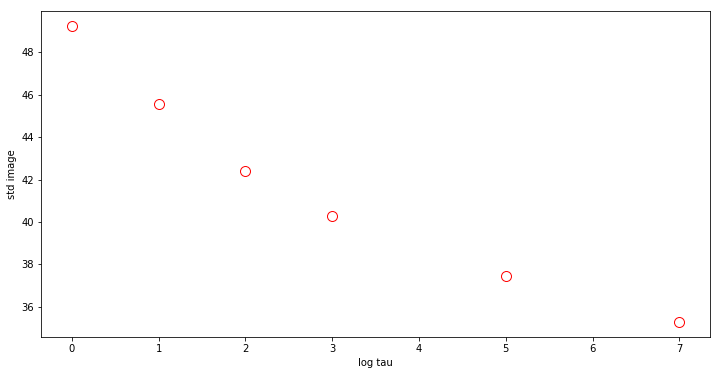

In [309]:
plt.figure(figsize=[12,6])
plt.scatter([0]+sigma,[np.std(b_gauss[i].ravel()) for i in range(6)],s=100,facecolor='w',edgecolor='r')
plt.xlabel('log tau')
plt.ylabel('std image')

The standard deviation decreases for larger sigma, which signals less noise. In comparison to the ridge regression images, the images smoothed with a gaussian are less sharp but have a larger dynamical range.

## 3 Automatic feature selection for regression

### 3.1 Implement Orthogonal Matching Pursuit

In [1]:
#import libs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_digits
from sklearn import model_selection

from scipy.sparse import dok_matrix, coo_matrix
from scipy.sparse.linalg import lsqr

In [2]:
def omp_regression(X,y,T):
    #initialization
    N,D = np.shape(X)
    A_0 = []
    B_0 = np.arange(0,D)
    r_0 = y
    solutions = np.zeros((D,T))
        
    #iteration
    for t in range(0,T):
        #1.
        j = np.argmax(np.absolute(X.T@r_0))
        print(j)
        
        #2.
        A_0.append(j)
        B_0 = np.delete(B_0,j)
                
        #3. 
        X_0 = np.array([X[:,j] for j in A_0]).T
        
        #4. use solver for beta
        beta_0 = lsqr(X_0,y)[0]
        
        #5.
        if (np.shape(beta_0) == 1):
            r_0 = y - X_0 * beta_0
        else:
            r_0 = y - X_0 @ beta_0

        #6. solutions
        for i in range(t+1):
            solutions[A_0[i],t]=beta_0[i]
        
    return solutions

### 3.2 Classification with sparse LDA

In [ ]:
def log_likelihood(x, mu, cov, p):
    """
    This function returns the log-likelihood for each data point x
    
    input x: N x 2 numpy array
    input: mu: 2 numpy array
    input: cov: 2 x 2 numpy array
    input: p: 1 float
    output logl: N x 2 numpy array
    """ 
    b = - 0.5 * np.log(np.linalg.det(2 * np.pi * cov)) + np.log(p)
    x = x - mu
    logl = -0.5 * (np.sum(x.T * np.dot(np.linalg.inv(cov), x.T), axis=0)) + b
    return logl


def data_preparation(digits, test_percentage = 0.33, random_seed=0):
    """
    This function filters the digits (1, 7) from the dataset and randomly splits it in train and test set.
    """
    data = digits["data"]
    target = digits["target"]
    
    # Data filering 
    num_1, num_2 = 1, 7
    mask = np.logical_or(target == num_1, target == num_2)
    data = data[mask]/data.max()
    target = target[mask]
    
    # Relabel targets
    target[target == num_1] = 1
    target[target == num_2] = -1

    # Random split
    x_training, x_test, y_training, y_test = model_selection.train_test_split(data, target, test_size=test_percentage,
                                                                      random_state=random_seed)
    
    
    return x_training, x_test, y_training, y_test


def fit_lda(training_features, training_labels):
    """
    This function compute for each class: mean and priors, and the global covariance matrix
    
    input training_features: N_training x 2 numpy array 
    input training_labels: N_training x 1 numpy array
    output lists of means, covariances and priors
    """
    mu, cov, p = [], [], []
    for label in np.unique(training_labels):
        # filtering the correct class
        data = training_features[training_labels == label]
        
        # mean
        mean = np.mean(data, axis=0)
        mu.append(mean)
        
        # Priors
        p.append(data.shape[0]/training_features.shape[0])
        
    # Global Variance, subtract class means first
    
    # computed as in texbook
    # global_feat = training_features - np.array(mu)[training_labels]
    # np.mean(training_features, axis=0)
    # cov = np.dot(global_feat.T, global_feat)/training_features.shape[0]
    
    # as numpy oneliner
    cov = np.cov(training_features.T)
    return mu, cov, p


def predict_lda(mu, cov, p, test_features):
    """
    This function returns the LDA predictions given
    as input lists of means, priors and the global covariance matrix
    input test_features: N_test x 2 numpy array 
    output: test_predictions: N_test numpy array
    """ 
    loglikelihood = np.zeros((test_features.shape[0], len(mu)))
    
    # Find the loglikelihood for each test point 
    for label in range(len(mu)):
        loglikelihood[:, label] = log_likelihood(test_features,
                                                 mu[label],
                                                 cov,
                                                 p[label])
    return np.argmax(loglikelihood, axis=-1)


def reduce_dim(x, beta_t):
    T = np.shape(beta_t)
    N,D = np.shape(x)
    x_sparse = np.zeros((N,D))
    for i in range(N):
        x_sparse[i,:] = np.multiply(x[i,:],beta_t)
    xr = np.nonzero(x_sparse)
    return x_sparse


In [ ]:
# Load data
digits = load_digits()

# Filering data 
x_training, x_test, y_training, y_test = data_preparation(digits, 0.33, 0)

So far, we copied in the data prepin order to get training and test sets containing:
X: Images as 64-dim vec of different grey levels
Y: Target-label {1,-1} indicating a 1 or 7 respectively

Now, we evaluate the error rates of our function omp_regression dependingon the number of features t in T we are allowed to represent the data set with.

In [ ]:
def get_accuracy(beta):
    T = np.shape(beta)[1]
    acc = np.zeros(T)
    for t in range(T):
        # Dimension Reduction
        xr_training, xr_test = reduce_dim(x_training,beta[:,t]), reduce_dim(x_test, beta[:,t]) 

        # Fit LDA
        mu, cov, p = fit_lda(xr_training, y_training)
        
        # Find LDA Predictions
        predicted_labels = predict_lda(mu, cov, p, xr_test)

        acc[t] = np.mean(predicted_labels == y_test)
        # Print accuracy
        print("Accuracy LDA: ", acc[t])
        
    return acc


T = 3
t = np.arange(1,T+1)

# Get subspaces up to T
solutions = omp_regression(x_training,y_training,T)

acc = get_accuracy(solutions)

plt.plot(t,acc)
plt.show()

In [ ]:
#NOT IMPORTANT - this cell can be ignored !

#show results for t=2

def scatter_plot_simple(x, y, title="Training"):
    """
    This function returns the dataset scatter plot 
    input x: N x 2 numpy array 
    input y: N x 1 numpy array
    output: None
    """ 
    plt.figure(figsize=(16, 9))
    plt.title(title + " Scatter Plot: 1 vs 7")

    # Scatter plot
    plt.scatter(x[y == -1, 19], x[y == -1, 3], marker="o", s=30, c="b", label= "1")
    plt.scatter(x[y == 1, 19], x[y == 1, 3], marker="x", s=30, c="r", label= "7")

    plt.xlabel("feature 1")
    plt.ylabel("feature 2")
    plt.legend()
    plt.show()

beta2 = solutions[:,1]
xr_training, xr_test = reduce_dim(x_training,beta2), reduce_dim(x_test, beta2) 
scatter_plot_simple(xr_training,y_training)

### 3.3 One-against-the-rest classication
missing